## The Problem: Imagine that you manage the design and technology for a collection of 256 advertising placements with a single publisher with websites devoted to golf; in this context a publisher is simply a website owner. Each placement is called an ad-unit and is associated with the ad-unit id= 1::256. The term ’ad-call’ is used to label the event when your server is asked for the data required to render the ad-unit for the user. Each ad-unit can be rendered in one of two treatments, called treatment 0 or 1. Perhaps treatments 0 and 1 differ in the size of the advertiser logos. Your technology group has afforded you a knob for each ad-unit, in the form of a number p[0:1]. Upon an ad-call for ad-uniti, your adserver draws a random number, and if this number is less than p then treatment 1 is shown, else treatment 0 is shown. To simplify this problem, assume that each adunit has exactly 1,000 ad-calls per day, and that each of the 256,000 ad-calls each day is due to a distinct user. Upon the ad-call, the user can interact with the ad-unit for an arbitrary number of seconds. For each second of interaction, an advertiser pays the publisher a cps (cost-per-second) c_ai which is a value specific to each ad-unit id_i and treatment id_a. You have an agreement with the publisher, that each day, the total advertiser spend divided by the total number of seconds of interaction, is no less than 0.20. Additionally, you have an internal requirement, that each day, the total number of adcalls (summed over all ad-units) with treatment 0 is equal to the number of adcalls with treatment 1.Your task is to choose the values of p_1::p_256 to maximize the expected total number of seconds of interaction (sum over all adcalls) that occur tomorrow, while guaranteeing both the publisher agreement and the internal requirement (in expectation).

In [1]:
import numpy 
import matplotlib 
from matplotlib import pyplot
import seaborn as sns 
import pandas
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
ad_info = pandas.read_json("data/ad_calls.json")

In [3]:
ad_info.keys()

Index([u'ad_unit_id', u'cost_per_second', u'n_seconds', u'treatment_id'], dtype='object')

#### Casually glancing through the file I see that treatment 0 always costs 0.32 c/s and 1 costs 0.16 c/s. Reformat the table so I can get the average values for treatment 0 and 1 for each of the ad_unit_ids (pandas pivot table automatically aggregates the entries by the mean for the table value)

In [4]:
ad_mean_pivot = pandas.pivot_table(ad_info,values='n_seconds', index=['ad_unit_id'],columns=['treatment_id'])

In [5]:
test = ad_info['n_seconds'][(ad_info['ad_unit_id']==0)&(ad_info['treatment_id']==1)]
print numpy.mean(test)

7.63993288107


In [6]:
ad_mean_pivot.head(n=5)

treatment_id,0,1
ad_unit_id,,
0,2.173420,7.639933
1,1.857541,3.647597
2,1.935385,3.941385
3,1.960112,8.335809
4,1.942295,3.814124


### To solve the problem I choose to use a greedy algorithm strategy. First I check the result optimizing only time, and see that the cost/second is less than 0.2. Therefore I create a second algorithm that alternates optimizing the time with optimizing the cost/second

In [7]:
#An algorithm that greedily optimizes the amount of time that ads are viewed
def get_weights(w_dict,o_vec,z_vec):
  cur_m1 = 128000
  cur_m0 = 128000    
  while(len(o_vec)>0):
    cur_uses = 1000
    m1_key = o_vec.keys()[0]
    m0_key = z_vec.keys()[0]
    m1_dur = o_vec[m1_key]
    m0_dur = z_vec[m0_key]
    #print len(os),len(zs),m1_key,m0_key,m1_dur,m0_dur
    while(cur_uses>0):
        if(m1_dur>=m0_dur):
            #print 'M1'
            if(cur_m1>0):
                w_dict[m1_key][1]+=1
                cur_uses-=1
                cur_m1-=1
            else:
                w_dict[m1_key][0]+=1
                cur_uses-=1
                cur_m0-=1
            if(cur_uses==0):
                o_vec.pop(m1_key)
                z_vec.pop(m1_key)
        else:
            #print 'M0'
            if(cur_m0>0):
                w_dict[m0_key][0]+=1
                cur_uses-=1
                cur_m0-=1
            else:
                w_dict[m0_key][1]+=1
                cur_uses-=1
                cur_m0-=1
            if(cur_uses==0):
                o_vec.pop(m0_key)
                z_vec.pop(m0_key)
    

In [8]:
#Test to check that total sum of uses for mode 0 and mode 1 are both 128000 and that the total is 256000
def test_weights(w_dict):
    tot_weight = 0
    w1 = 0
    w0 = 0
    for key,weights in w_dict.iteritems():
        tot_weight+=sum(weights)
        w1+=weights[1]
        w0+=weights[0]
    assert(tot_weight==256000)
    assert(w1==128000)
    assert(w0==128000)

In [9]:
one_cost = ad_info['cost_per_second'][ad_info['treatment_id']==1]
zero_cost = ad_info['cost_per_second'][ad_info['treatment_id']==0]

#### Confirm that treatment 1 always costs 0.16 and treatment 0 always costs 0.32

In [10]:
one_cost[one_cost!=0.16]

Series([], name: cost_per_second, dtype: float64)

In [11]:
zero_cost[zero_cost!=0.32]

Series([], name: cost_per_second, dtype: float64)

In [12]:
#An algorithm to calculate the cost/second from the weights calculated by get_weights()
def calculate_cost_time(w_dict,o_cs,z_cs,o_vec,z_vec):
    tot_cost = 0
    tot_time = 0
    for key,weights in w_dict.iteritems():
        tot_cost+=z_cs[key]*weights[0]
        tot_cost+=o_cs[key]*weights[1]  
        tot_time+=z_vec[key]*weights[0]
        tot_time+=o_vec[key]*weights[1]
    return tot_cost,tot_time

In [13]:
zs = ad_mean_pivot[0].copy()
zs.sort(ascending=False)
os = ad_mean_pivot[1].copy()
os.sort(ascending=False)

#### Show that if I optimize time only that the cost/second is ~0.1925, which is less than 0.2

In [14]:
weight_dict2 = {key: [0,0] for key in xrange(0,256)}
get_weights(weight_dict2,os,zs)
test_weights(weight_dict2)

In [15]:
zs = ad_mean_pivot[0].copy()
os = ad_mean_pivot[1].copy()
z_cost_time = 0.32*zs
o_cost_time = 0.16*os

In [16]:
tot_cost,tot_time = calculate_cost_time(weight_dict2,o_cost_time,z_cost_time,os,zs)
print (tot_cost)/(tot_time),tot_cost,tot_time

0.192516255221 243300.115643 1263789.98679


#### Test deciding the weights entirely based on the c/s

In [17]:
zs = ad_mean_pivot[0].copy()
zs.sort(ascending=False)
os = ad_mean_pivot[1].copy()
os.sort(ascending=False)

In [18]:
#An algorithm that uses the current average cost/second to decide whether to greedily optimize for time or for cost
def get_weights_avg(w_dict,o_vec,z_vec,cost_threshold=0.2):
    cur_m1 = 128000
    cur_m0 = 128000    
    cur_cost = 0.
    cur_time = 0.
    use_dict = {key: 1000 for key in xrange(0,256)}
    while(len(o_vec)>0):
        m1_key = o_vec.keys()[0]
        m0_key = z_vec.keys()[0]
        m0_dur = z_vec[m0_key]
        ''''Since I know that treatment 1 always costs 0.16 and treatment 0 always costs 0.32 I can just force
        the algorithm to use treatment 0 if the cost dips below the threshold, and choose the longest duration
        otherwise'''
        if(cur_time==0 or (cur_cost/cur_time)<cost_threshold):
            m1_dur=0
        else:
            m1_dur = o_vec[m1_key]
        if(m1_dur>=m0_dur):
            if(cur_m1>0):
                cur_cost+=0.16*m1_dur
                cur_time+=m1_dur
                w_dict[m1_key][1]+=1
                use_dict[m1_key]-=1
                cur_m1-=1
            else:
                cur_cost+=0.32*z_vec[m1_key]
                cur_time+=z_vec[m1_key]
                w_dict[m1_key][0]+=1
                use_dict[m1_key]-=1
                cur_m0-=1
            if(use_dict[m1_key]==0):
                o_vec.pop(m1_key)
                z_vec.pop(m1_key)
        else:
            if(cur_m0>0):
                cur_cost+=0.32*m0_dur
                cur_time+=m0_dur
                w_dict[m0_key][0]+=1
                use_dict[m0_key]-=1
                cur_m0-=1
            else:
                cur_cost+=0.16*z_vec[m0_key]
                cur_time+=z_vec[m0_key]
                w_dict[m0_key][1]+=1
                use_dict[m0_key]-=1
                cur_m0-=1
            if(use_dict[m0_key]==0):
                o_vec.pop(m0_key)
                z_vec.pop(m0_key)

In [19]:
weight_dict = {key: [0,0] for key in xrange(0,256)}

In [20]:
get_weights_avg(weight_dict,os,zs)
test_weights(weight_dict)

In [21]:
zs = ad_mean_pivot[0].copy()
zs.sort(ascending=False)
os = ad_mean_pivot[1].copy()
os.sort(ascending=False)
z_cost_time = 0.32*zs
o_cost_time = 0.16*os

#### See that if I set the threshold at 0.2 that my cost/second improves, and my total time decreases, but this threshold is not yet high enough to get me to the 0.2 cents/second that I need. Therefore I need to tune my cost threshold

In [22]:
tot_cost,tot_time = calculate_cost_time(weight_dict,o_cost_time,z_cost_time,os,zs)
print (tot_cost)/(tot_time),tot_cost,tot_time

0.19721800021 223586.147133 1133700.50855


In [23]:
thresh_list = []
cost_list = []
time_list = []
for t_hold in numpy.linspace(0.16,0.32,20):
    weight_dict = {key: [0,0] for key in xrange(0,256)}
    get_weights_avg(weight_dict,os,zs,t_hold)
    test_weights(weight_dict)
    zs = ad_mean_pivot[0].copy()
    zs.sort(ascending=False)
    os = ad_mean_pivot[1].copy()
    os.sort(ascending=False)
    z_cost_time = 0.32*zs
    o_cost_time = 0.16*os
    tot_cost,tot_time = calculate_cost_time(weight_dict,o_cost_time,z_cost_time,os,zs)
    thresh_list.append(t_hold)
    cost_list.append((tot_cost)/(tot_time))
    time_list.append(tot_time)
    #print i,(tot_cost)/(tot_time),tot_cost,tot_time

#### Show that as the threshold increases the total time that the ads are viewed always decreases

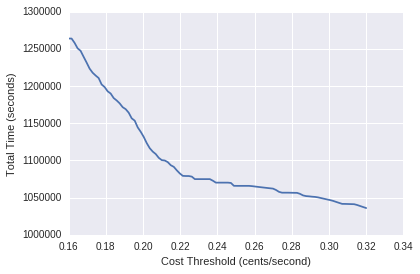

In [37]:
ax = pyplot.plot(thresh_list,time_list)
pyplot.xlabel("Cost Threshold (cents/second)")
pyplot.ylabel("Total Time (seconds)")

#### Plot results of iteration to see what the value of the cost threshold is that maximizes the total time

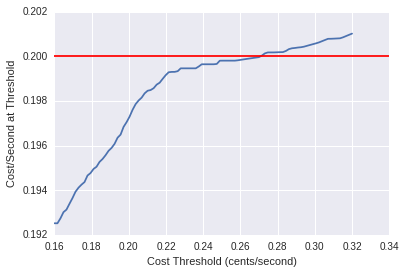

In [34]:
ax = pyplot.plot(thresh_list,cost_list)
pyplot.axhline(y=0.2,color='r')
pyplot.xlabel("Cost Threshold (cents/second)")
pyplot.ylabel("Cost/Second at Threshold")

#### Use a spline to calculate the value of the threshold where the cost/second is 0.2

In [50]:
from scipy.interpolate import interp1d
spl = interp1d(cost_list, thresh_list)
best_threshold = spl(0.2)

#### Calculate the weights at the best threshold

In [52]:
zs = ad_mean_pivot[0].copy()
zs.sort(ascending=False)
os = ad_mean_pivot[1].copy()
os.sort(ascending=False)
z_cost_time = 0.32*zs
o_cost_time = 0.16*os
fin_weight_dict = {key: [0,0] for key in xrange(0,256)}
get_weights_avg(fin_weight_dict,os,zs,best_threshold)
test_weights(fin_weight_dict)